# Google Cloud Platform - Using Machine Learning APIs  ).

This is an upgraded Python revision of [this notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/CPB100/lab4c/mlapis.ipynb).

This notebook originally was being processed using DataLab on the Google Cloud Platform.  This particular incarnation of the notebook is for running on Google Colaboratory which I am trying out for the first time.

### Security

First things first - we need to authenticate against the Google Cloud APIs.

#### Getting a Google API Credential.

First, visit <a href="http://console.cloud.google.com/apis">API console</a>, choose "Credentials" on the left-hand menu.  Choose "Create Credentials" and generate an API key for your application. You should probably restrict it by IP address to prevent abuse, but for now, just  leave that field blank and delete the API key after trying out this demo.

Then, when you have your key, you will enter it in this first executable cell:

In [1]:

'''
!pip install -q cloudstorage
!pip install -q webapp2
!pip install --upgrade numpy
!pip install six==1.10.0
!pip install -q datalab
!pip install --upgrade gcs-client
!pip install --upgrade google-cloud-storage
!pip install --upgrade google-api-python-client
!pip install opencv-python
!pip install gcsfs
'''

'\n!pip install -q cloudstorage\n!pip install -q webapp2\n!pip install --upgrade numpy\n!pip install six==1.10.0\n!pip install -q datalab\n!pip install --upgrade gcs-client\n!pip install --upgrade google-cloud-storage\n!pip install --upgrade google-api-python-client\n!pip install opencv-python\n!pip install gcsfs\n'

In [2]:
import getpass

APIKEY = getpass.getpass()

··········


In [3]:
import sys
import json
import argparse
import googleapiclient.discovery
import pandas as pd
import skimage.data
from skimage import img_as_float
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import io


import sys
import json
import argparse
import googleapiclient.discovery
import pandas as pd
import skimage.data
from skimage import img_as_float
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import io
from google.cloud import storage


import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import matplotlib.image as mpimg


Using TensorFlow backend.


In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

# Create the service client.
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')




In [0]:
def download_content(file):
    client = storage.Client.from_service_account_json(
    GOOGLE_APPLICATION_CREDENTIALS)
    bucket = client.get_bucket(BUCKET)
    blob = storage.Blob(test_file, bucket)
    content = blob.download_as_string()
    return(content)

In [0]:
def plot_image(filename):
  from google.cloud import storage
  client = storage.Client('MLRobustClassifier')
  bucket = client.get_bucket(BUCKET)
  blob = storage.Blob(filename, bucket)
  content = blob.download_as_string()
  img = Image.open(io.BytesIO(content))
  import matplotlib.pyplot as plt

  plt.imshow(img)
  plt.show()

In [0]:
def strip_filepath(infiles):
    strip=[]
    for path in infiles:
        res=path.split("/")
        res=res[1]
        res=res.split('.')
        res=res[0]
        strip.append(res)
    files=pd.DataFrame()
    files['ImageID']=strip
    files['Url']=infiles
    return(files)

In [0]:
def list_bucket_pf(bucket, pf):
    """Returns a list of metadata of the objects within the given bucket."""
    service = create_service()

    # Create a request to objects.list to retrieve a list of objects.
    fields_to_return = 'nextPageToken,items(name,size,contentType,metadata(my-key))'
    req = service.objects().list(bucket=bucket, fields=fields_to_return, prefix=pf)  # returns everything. UrbanSound is top dir in bucket

    all_objects = []
    # If you have too many items to list in one request, list_next() will
    # automatically handle paging with the pageToken.
    while req:
        resp = req.execute()
        all_objects.extend(resp.get('items', []))
        req = service.objects().list_next(req, resp)
    return all_objects



In [0]:
def process_image(filename):
  from google.cloud import storage
  client = storage.Client('MLRobustClassifier')
  bucket = client.get_bucket(BUCKET)
  blob = storage.Blob(filename, bucket)
  content = blob.download_as_string()
  img = Image.open(io.BytesIO(content)).convert('L')
  size = 256,256
  img = img.resize(size, Image.ANTIALIAS)
  img=np.array(img)
  return(img)

In [93]:
process_image('Boat/002200be72145198.jpg')

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [183, 184, 179, ..., 178, 178, 179],
       [235, 245, 248, ..., 176, 182, 186],
       [244, 244, 235, ..., 173, 182, 182]], dtype=uint8)

In [0]:
BUCKET='wpiopenimageskaggle'


In [0]:
def create_Labeldict(bucket,objs,count):
    
      imgLabelDict={}
      labelDict={}
      img_ids=[]
      imgs=[]
      labels=[]

      mini_batch, labels_mini_batch=create_minibatch(bucket, objs,count)
      cnt=(len(mini_batch['ImageID']))
      print(cnt)
      
      for i in range(0,cnt):
        label=labels_mini_batch[i]
        print(label)
        unit=[]
        unit.append(mini_batch['ImageID'][i])
        unit.append(process_image(mini_batch['Url'][i]))
        imid=mini_batch['ImageID'][i]
        
        if label in labels:
          prev=imgLabelDict.get(label)
          prev=prev.append(unit)
          prev_l=labelDict.get(label)
          prev_l=prev_l.append(imid)
          print(prev_l)
          
        else:
          labels.append(label)
          prev=unit
          prev_l=[]
          prev_l=prev_l.append(imid)
          print(prev_l)
          imgLabelDict[label]=prev
          labelDict[label]=prev_l
        
        
        imgLabelDict[label]=prev
        labelDict[label]=prev_l
        
      return labelDict, imgLabelDict 

In [0]:
def create_minibatch(BUCKET, objs,size):
    groups=[]
    labels=[]
    for obj in objs:
        res=json.dumps(list_bucket_pf(BUCKET, obj), indent=2)
        test=pd.read_json(res)
        files=test['name']
        groups.append(files)
    mini_batch=[]
    labels_mini_batch=[]

    for i in range(0, len(objs)):
        for j in range(1,size):
            mini_batch.append(groups[i][j])
            labels_mini_batch.append(objs[i])
    mini_batch=strip_filepath(mini_batch)    
    return mini_batch, labels_mini_batch

In [169]:
labelDict, imgLabelDict=create_Labeldict(BUCKET, ['Table', 'Tree'],8)
print(labelDict)

14
Table
None
Table
None


AttributeError: ignored

In [0]:
def CreateBatchOfImages(bucket, batchSize, labelDict):

    
    ImageLabelDict=labelDict
    labelDict=[]
    Success_Num=10
    
    return ImageLabelDict, labelDict, SuccessNum

In [0]:
#class_set=['/m/019jd','/m/0cgh4','/m/0bt9lr', '/m/0jyfg', '/m/03vt0', '/m/04bcr3', '/m/07j7r', '/m/01g317']

In [0]:
objs=['Table', 'Tree', 'Person', 'Boat']

In [0]:

mini_batch,labels=create_minibatch(BUCKET, objs, size)

***BELOW THIS POINT IS CODE TRIED THAT DOESN'T WORK KEPT FOR REFERENCE***

In [0]:
def create_minibatch(bucket, objs, size):
  labels=[]
  data=[]
  for obj in objs:
    batch=batch=CreateBatchOfImages(BUCKET,batch_size,obj)
    #batch=CreateBatchOfImages(batch_size,obj)
    label_batch= np.chararray(size)
    label_batch[:]=obj
    labels.append(label_batch)
    data.append(batch)
    
    
        
  

In [0]:
objs=['Table', 'Tree', 'Person', 'Boat']
mini_batch, labels=create_minibatch(BUCKET,objs)

In [0]:
image_info=strip_filepath(mini_batch)

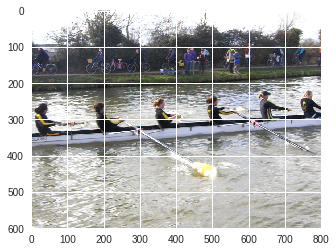

In [0]:
  #filename='imageIds/PointAnnotationsSet256.txt'
  filename=test_file

Boat/002200be72145198.jpg


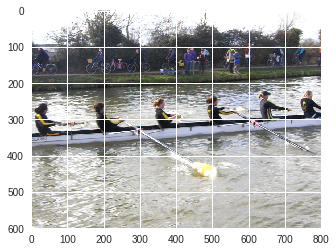

Boat/0025a6cccec41134.jpg


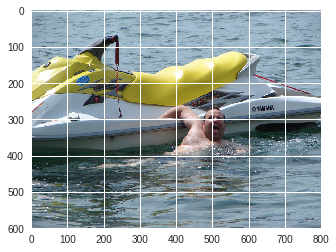

Boat/003d4acb635f05b7.jpg


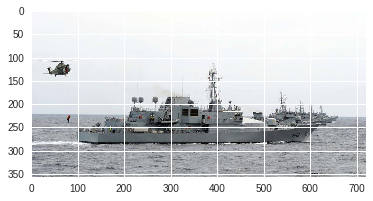

Boat/00a9f6e69fd697b3.jpg


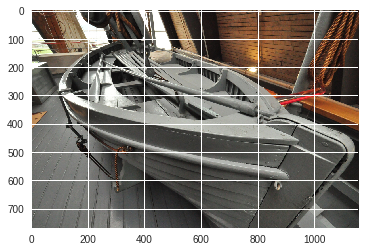

Boat/022f3d093aeced7c.jpg


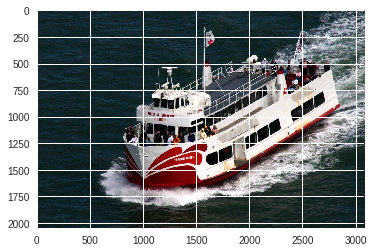

Boat/024fb208337d48ad.jpg


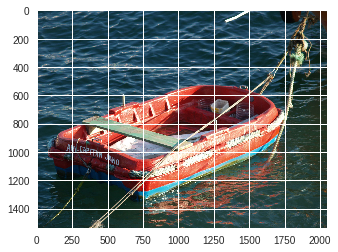

Boat/0250382927a9c897.jpg


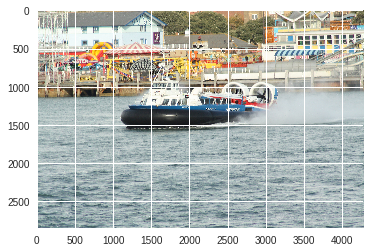

Boat/027c641af2ada700.jpg


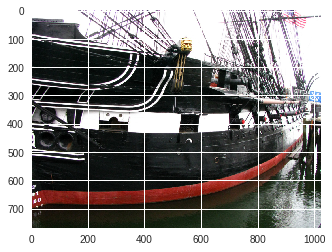

Boat/02914fda0e8fcf20.jpg


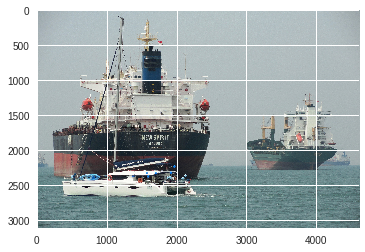

In [0]:
for id in range(1,10):
  test_file=test['name'].apply(str)[id]
  print(test_file)
  plot_image(test_file)
  

In [0]:
def create_service():
    return googleapiclient.discovery.build('storage', 'v1')


def list_bucket_pf(bucket, pf):
    """Returns a list of metadata of the objects within the given bucket."""
    service = create_service()

    # Create a request to objects.list to retrieve a list of objects.
    fields_to_return = 'nextPageToken,items(name,size,contentType,metadata(my-key))'
    req = service.objects().list(bucket=bucket, fields=fields_to_return, prefix=pf)  # returns everything. UrbanSound is top dir in bucket

    all_objects = []
    # If you have too many items to list in one request, list_next() will
    # automatically handle paging with the pageToken.
    while req:
        resp = req.execute()
        all_objects.extend(resp.get('items', []))
        req = service.objects().list_next(req, resp)
    return all_objects

